# Visualizing Data for Classification

In the previous lab, you explored the automotive price dataset to understand the relationships for a regression problem. In this lab you will explore the German bank credit dataset to understand the relationships for a **classification** problem. The difference being, that in classification problems the label is a categorical variable. 

In other labs you will use what you learn through visualization to create a solution that predicts the customers with bad credit. For now, the focus of this lab is on visually exploring the data to determine which features may be useful in predicting customer's bad credit.

Visualization for classification problems shares much in common with visualization for regression problems. Colinear features should be identified so they can be eliminated or otherwise dealt with. However, for classification problems you are looking for features that help **separate the label categories**. Separation is achieved when there are distinctive feature values for each label category. Good separation results in low classification error rate.

## Load and prepare the data set

As a first step you must load the dataset. 

Execute the code in the cell below to load the packages required for the rest of this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math

data_dir = './datasets/'

%matplotlib inline

The code in the cell below loads the dataset and assigns human-readable names to the columns. The shape and head of the data frame are then printed. Execute this code:

In [2]:
credit = pd.read_csv(data_dir+'German_Credit.csv', header=None)
credit.columns = ['customer_id',
                  'checking_account_status', 'loan_duration_mo', 'credit_history', 
                  'purpose', 'loan_amount', 'savings_account_balance', 
                  'time_employed_yrs', 'payment_pcnt_income','gender_status', 
                  'other_signators', 'time_in_residence', 'property', 'age_yrs',
                  'other_credit_outstanding', 'home_ownership', 'number_loans', 
                  'job_category', 'dependents', 'telephone', 'foreign_worker', 
                  'bad_credit']
print(credit.shape)
credit.head()

(1012, 22)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,A11,6,A34,A43,1169,A65,A75,4,A93,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,6156361,A12,48,A32,A43,5951,A61,A73,2,A92,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,2051359,A14,12,A34,A46,2096,A61,A74,2,A93,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,8740590,A11,42,A32,A42,7882,A61,A74,2,A93,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,3924540,A11,24,A33,A40,4870,A61,A73,3,A93,...,A124,53,A143,A153,2,A173,2,A191,A201,2


There are 1011 rows and 22 columns in the dataset. The first column is customer_id, which is an identifier. We will drop this since this is not a feature.

In [3]:
credit.drop(['customer_id'], axis=1, inplace=True)
print(credit.shape)
credit.head()

(1012, 21)


,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,other_signators,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Now, there are 21 columns left. Of the 21 columns, there are 20 features plus a label column. These features represent information a bank might have on its customers. There are both numeric and categorical features. However, the categorical features are coded in a way that makes them hard to understand. Further, the label is coded as $\{ 1,2 \}$ which is a bit awkward. 

The code in the cell below using a list of dictionaries to recode the categorical features with human-readable text. The final dictionary in the list recodes good and bad credit as a binary variable, $\{ 0,1 \}$. The `for` loop iterates over the columns and maps codes to human-readable category names. Having human readable coding of data greatly improves peoples' ability to understand the relationships in the data.

Execute this code and examine the result: 

In [4]:
code_list = [['checking_account_status', 
              {'A11' : '< 0 DM', 
               'A12' : '0 - 200 DM', 
               'A13' : '> 200 DM or salary assignment', 
               'A14' : 'none'}],
            ['credit_history',
            {'A30' : 'no credit - paid', 
             'A31' : 'all loans at bank paid', 
             'A32' : 'current loans paid', 
             'A33' : 'past payment delays', 
             'A34' : 'critical account - other non-bank loans'}],
            ['purpose',
            {'A40' : 'car (new)', 
             'A41' : 'car (used)',
             'A42' : 'furniture/equipment',
             'A43' : 'radio/television', 
             'A44' : 'domestic appliances', 
             'A45' : 'repairs', 
             'A46' : 'education', 
             'A47' : 'vacation',
             'A48' : 'retraining',
             'A49' : 'business', 
             'A410' : 'other' }],
            ['savings_account_balance',
            {'A61' : '< 100 DM', 
             'A62' : '100 - 500 DM', 
             'A63' : '500 - 1000 DM', 
             'A64' : '>= 1000 DM',
             'A65' : 'unknown/none' }],
            ['time_employed_yrs',
            {'A71' : 'unemployed',
             'A72' : '< 1 year', 
             'A73' : '1 - 4 years', 
             'A74' : '4 - 7 years', 
             'A75' : '>= 7 years'}],
            ['gender_status',
            {'A91' : 'male-divorced/separated', 
             'A92' : 'female-divorced/separated/married',
             'A93' : 'male-single', 
             'A94' : 'male-married/widowed', 
             'A95' : 'female-single'}],
            ['other_signators',
            {'A101' : 'none', 
             'A102' : 'co-applicant', 
             'A103' : 'guarantor'}],
            ['property',
            {'A121' : 'real estate',
             'A122' : 'building society savings/life insurance', 
             'A123' : 'car or other',
             'A124' : 'unknown-none' }],
            ['other_credit_outstanding',
            {'A141' : 'bank', 
             'A142' : 'stores', 
             'A143' : 'none'}],
             ['home_ownership',
            {'A151' : 'rent', 
             'A152' : 'own', 
             'A153' : 'for free'}],
            ['job_category',
            {'A171' : 'unemployed-unskilled-non-resident', 
             'A172' : 'unskilled-resident', 
             'A173' : 'skilled',
             'A174' : 'highly skilled'}],
            ['telephone', 
            {'A191' : 'none', 
             'A192' : 'yes'}],
            ['foreign_worker',
            {'A201' : 'yes', 
             'A202' : 'no'}],
            ['bad_credit',
            {2 : 1,
             1 : 0}]]

for col_dic in code_list:
    col = col_dic[0]
    dic = col_dic[1]
    credit[col] = [dic[x] for x in credit[col]]
    
credit.head()    

,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,other_signators,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1


The categorical features now have meaningful coding. Additionally, the label is now coded as a binary variable. 

## Examine classes and class imbalance

In this case, the label has significant **class imbalance**. Class imbalance means that there are  unequal numbers of cases for the categories of the label. Class imbalance can seriously bias the training of classifier algorithms. It many cases, the imbalance leads to a higher error rate for the minority class. Most real-world classification problems have class imbalance, sometimes severe class imbalance, so it is important to test for this before training any model. 

Fortunately, it is easy to test for class imbalance using a frequency table. Execute the code in the cell below to display a frequency table of the classes: 

In [5]:
credit_counts = credit['bad_credit'].value_counts()
print(credit_counts)

0    710
1    302
Name: bad_credit, dtype: int64


Notice that only 30% of the cases have bad credit. This is not surprising, since a bank would typically retain customers with good credit. While this is not a cases of severe imbalance, it is enough to bias the training of any model. 

## Visualize class separation by numeric features

As stated previously, the primary goal of visualization for classification problems is to understand which features are useful for class separation. In this section, you will start by visualizing the separation quality of numeric features. 

Execute the code, examine the results, and answer **Question 1** on the course page.

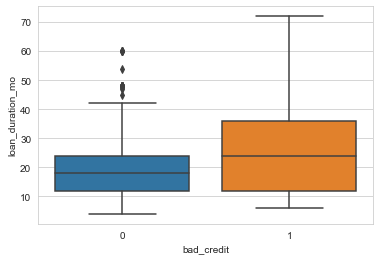

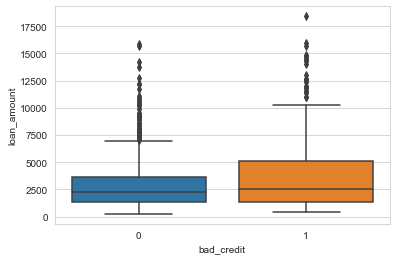

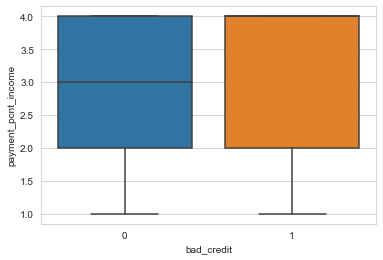

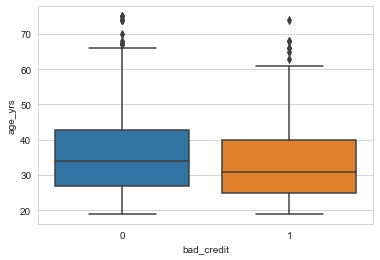

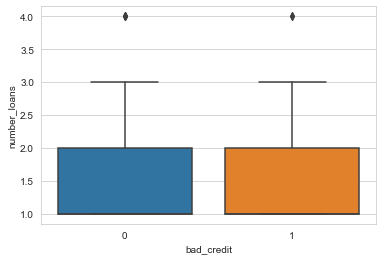

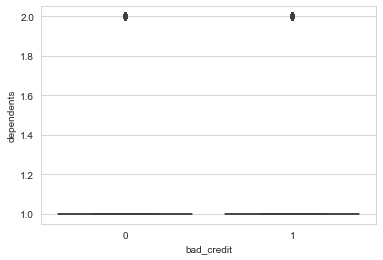

In [6]:
def plot_box(credit, cols, col_x = 'bad_credit'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col_x, col, data=credit)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
            'age_yrs', 'number_loans', 'dependents']
plot_box(credit, num_cols)

How can you interpret these results? Box plots are useful, since by their very construction you are forced to focus on the overlap (or not) of the quartiles of the distribution. In this case, the question is there sufficient differences in the quartiles for the feature to be useful in separation the label classes? The following cases are displayed in the above plots:
1. For loan_duration_mo, loan_amount, and payment as a percent of income (payment_pcnt_income), there is useful separation between good and bad credit customers. As one might expect, bad credit customers have longer loan duration on larger loans and with payments being a greater percentage of their income. 
2. On the other hand, age in years, number_loans and dependents does not seem to matter. In latter two cases, this situation seems to result from the median value being zero. There are just not enough non-zero cases to make these useful features. 

As an alternative to box plots, you can use violin plots to examine the separation of label cases by numeric features. Execute the code in the cell below and examine the results:

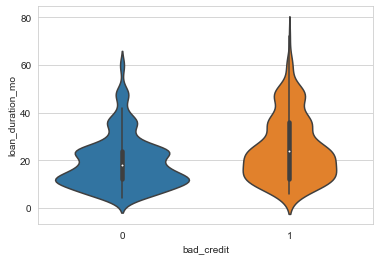

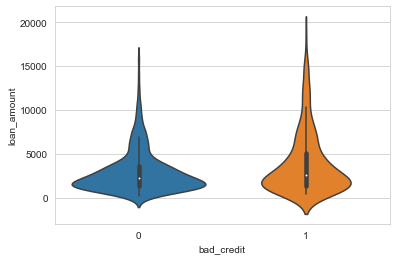

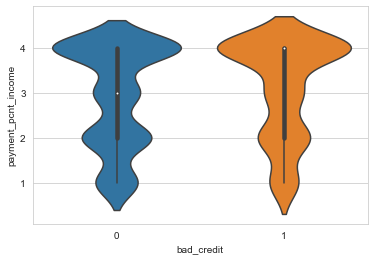

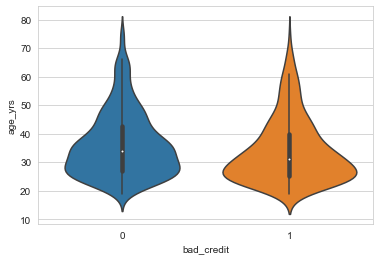

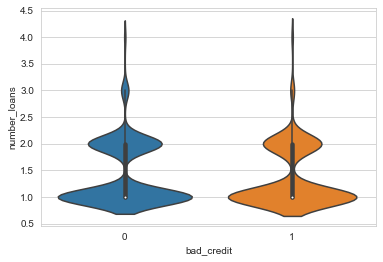

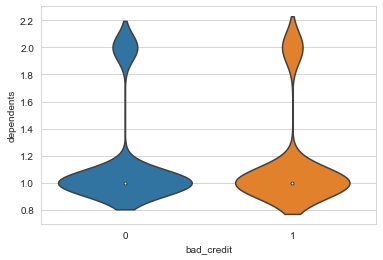

In [7]:
def plot_violin(credit, cols, col_x = 'bad_credit'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.violinplot(col_x, col, data=credit)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

plot_violin(credit, num_cols)

The interpretation of these plots is largely the same as the box plots. However, there is one detail worth noting. The differences between loan_duration_mo and loan_amount for good and bad credit customers are only for the more extreme values. It may be that these features are less useful and the box plot indicates. 

## Visualize class separation by categorical features

Now you will turn to the problem of visualizing the ability of categorical features to separate classes of the label. Ideally, a categorical feature will have very different counts of the categories for each of the label values. A good way to visualize these relationships is with bar plots.

The code in the cell below creates side by side plots of the categorical variables for each of the labels categories. 

Execute this code, examine the results, and answer **Question 2** on the course page.

checking_account_status


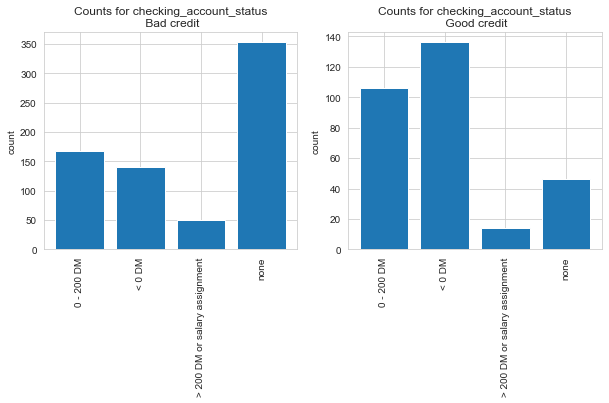

credit_history


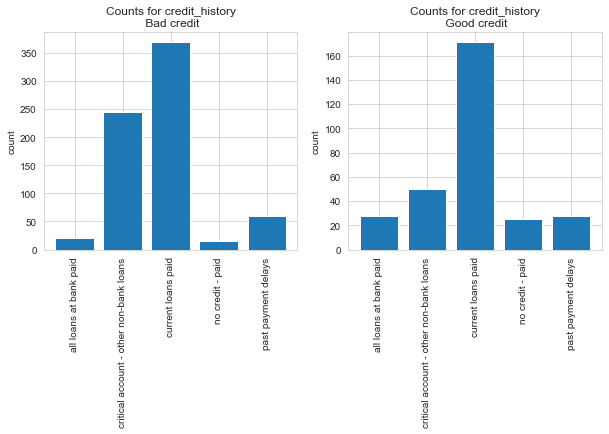

purpose


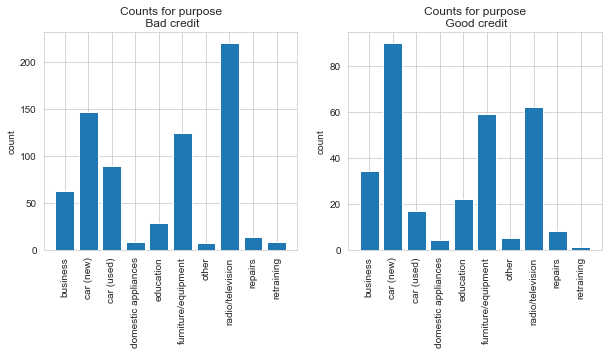

savings_account_balance


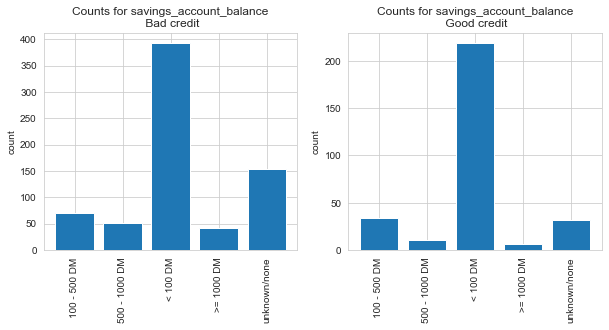

time_employed_yrs


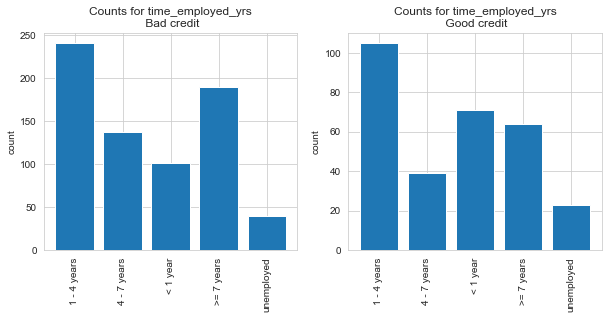

gender_status


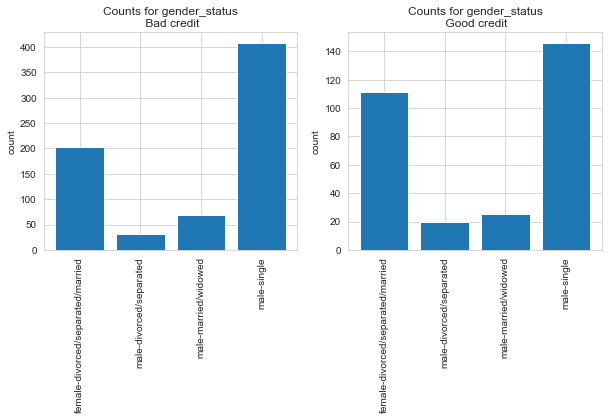

other_signators


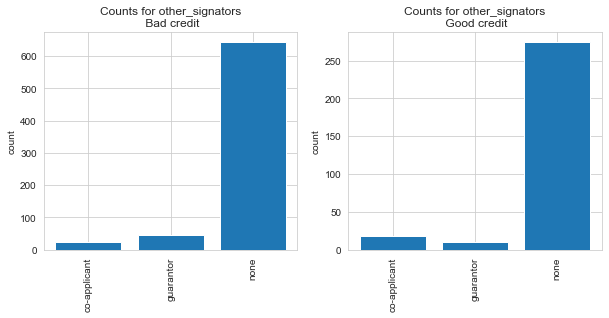

property


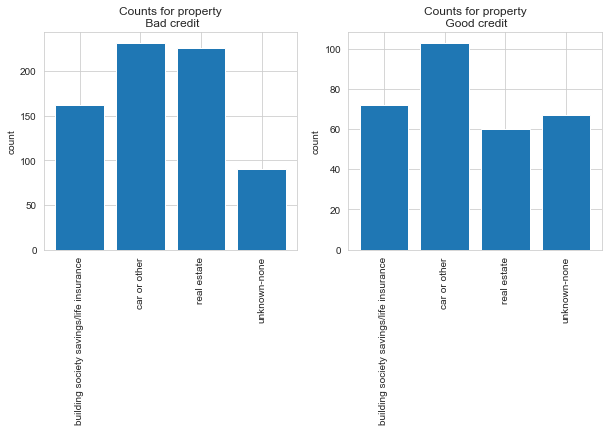

other_credit_outstanding


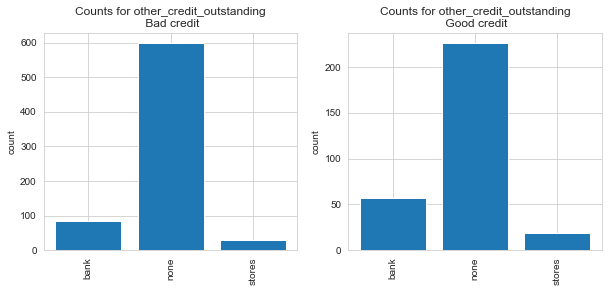

home_ownership


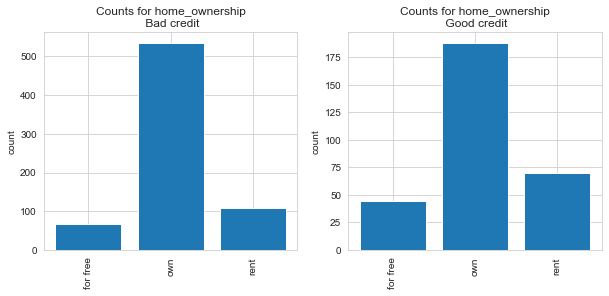

job_category


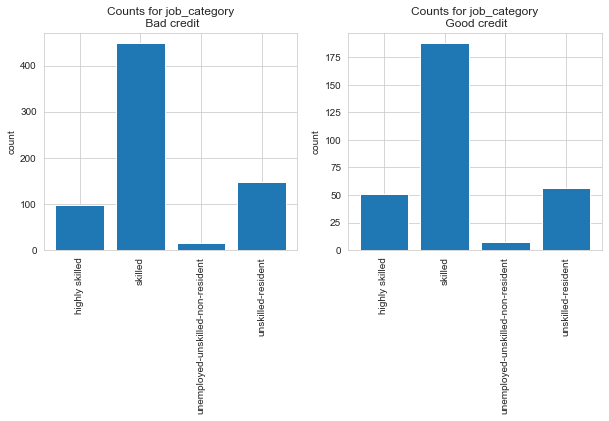

telephone


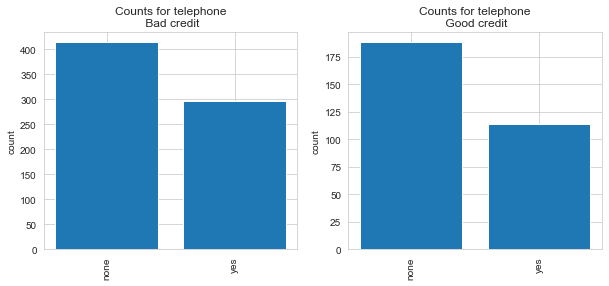

foreign_worker


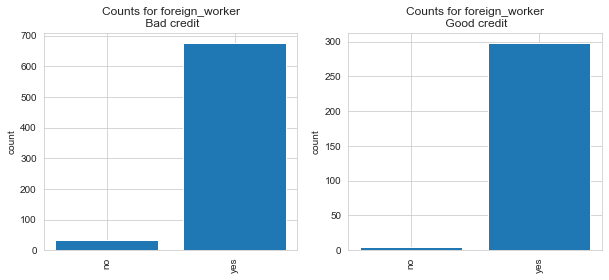

In [8]:
import numpy as np
cat_cols = ['checking_account_status', 'credit_history', 'purpose', 'savings_account_balance', 
                  'time_employed_yrs', 'gender_status', 'other_signators', 'property', 
                  'other_credit_outstanding', 'home_ownership', 'job_category', 'telephone', 
                  'foreign_worker']

credit['dummy'] = np.ones(shape = credit.shape[0])
for col in cat_cols:
    print(col)
    counts = credit[['dummy', 'bad_credit', col]].groupby(['bad_credit', col], as_index = False).count()
    temp = counts[counts['bad_credit'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (10,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['bad_credit'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Bad credit')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['bad_credit'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Good credit')
    plt.ylabel('count')
    plt.show()

There is a lot of information in these plots. The key to interpreting these plots is comparing the proportion of the categories for each of the label values. If these proportions are distinctly different for each label category, the feature is likely to be useful in separating the label.  

There are several cases evident in these plots:
1. Some features such as checking_account_status and credit_history have significantly different distribution of categories between the label categories. 
2. Others features such as gender_status and telephone show small differences, but these differences are unlikely to be significant. 
3. Other features like other_signators, foreign_worker, home_ownership, and job_category have a dominant category with very few cases of other categories. These features will likely have very little power to separate the cases.  

Notice that only a few of these categorical features will be useful in separating the cases. 

## Summary

In this lab you have performed exploration and visualization to understand the relationships in a classification dataset. Specifically:
1. Examine the imbalance in the label cases using a frequency table. 
2. Find numeric or categorical features that separate the cases using visualization.